In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [70]:
# df_ground_truth = pd.read_csv('../annotations/ground_truth_sample.csv', index_col=0, sep=';')
# df_yolo_predictions = pd.read_csv('../annotations/yolo_labels_sample.csv', index_col=0, sep=';')
# TODO: add +1 for frame_id in yolo real predictions

df_ground_truth = pd.read_csv('../annotations/ground_truth_boat_frames_coco.csv', index_col=0, sep=';')
df_yolo_predictions = pd.read_csv('../annotations/yolov8x_no_train_labels.csv', index_col=0, sep=';')

df_ground_truth['datetime'] = pd.to_datetime(df_ground_truth.datetime)
df_ground_truth['date'] = df_ground_truth.datetime.dt.date
df_yolo_predictions['datetime'] = pd.to_datetime(df_yolo_predictions['datetime'])
df_yolo_predictions['date'] = pd.to_datetime(df_yolo_predictions.datetime.dt.date, format='%Y-%m-%d')
print('shape of loaded data', df_ground_truth.shape, df_yolo_predictions.shape)
print(df_ground_truth.groupby(['date', 'camera_id']).datetime.count())
print(df_yolo_predictions.groupby(['date', 'camera_id']).datetime.count())

df_yolo_predictions = df_yolo_predictions[\
    ((df_yolo_predictions.date == '2023-06-09') & (df_yolo_predictions.camera_id.isin([1,2]))) |\
    ((df_yolo_predictions.date == '2023-06-10') & (df_yolo_predictions.camera_id == 2)) |\
    ((df_yolo_predictions.date == '2023-07-07') & (df_yolo_predictions.camera_id == 2)) |\
    ((df_yolo_predictions.date == '2023-07-08') & (df_yolo_predictions.camera_id == 1)) \
].copy()

df_yolo_predictions.drop(index=df_yolo_predictions[(df_yolo_predictions.camera_id == 2) & (df_yolo_predictions.x > 1800)].index, inplace=True)
df_ground_truth.drop(index=df_ground_truth[(df_ground_truth.camera_id == 2) & (df_ground_truth.x > 1800)].index, inplace=True)

df_ground_truth.set_index('filename', inplace=True)
df_yolo_predictions.set_index('filename', inplace=True)

df_ground_truth.shape, df_yolo_predictions.shape

shape of loaded data (25443, 11) (826239, 11)
date        camera_id
2023-06-09  1            4149
            2            3481
2023-06-10  2            6321
2023-07-07  2            6500
2023-07-08  1            4992
Name: datetime, dtype: int64
date        camera_id
2023-06-09  1            214940
            2             12452
2023-06-10  1            132223
            2             28347
2023-06-11  1             65558
            2              5577
2023-07-07  2            189338
2023-07-08  1            177804
Name: datetime, dtype: int64


((24870, 10), (499154, 10))

In [74]:
df_yolo_predictions_frame_indexed = df_yolo_predictions.reset_index().set_index(['filename', 'frame_id'])
df_yolo_predictions_frame_indexed.shape

(499154, 9)

In [87]:
def calculate_iou(ground_truth:tuple, prediction:tuple):
    """
        Calculate intersection over union for two bounding boxes.
        Args:
            ground_truth: tuple of (x, y, w, h)
            prediction: tuple of (x, y, w, h)
    """
    gt_xtl = ground_truth[0]-ground_truth[2]/2
    gt_ytl = ground_truth[1]-ground_truth[3]/2
    gt_xbr = ground_truth[0]+ground_truth[2]/2
    gt_ybr = ground_truth[1]+ground_truth[3]/2
    pr_xtl = prediction[0]-prediction[2]/2
    pr_ytl = prediction[1]-prediction[3]/2
    pr_xbr = prediction[0]+prediction[2]/2
    pr_ybr = prediction[1]+prediction[3]/2
    intersection_xtl = max(gt_xtl, pr_xtl)
    intersection_ytl = max(gt_ytl, pr_ytl)
    intersection_xbr = min(gt_xbr, pr_xbr)
    intersection_ybr = min(gt_ybr, pr_ybr)
    intersection_area = max(0, intersection_xbr - intersection_xtl) * max(0, intersection_ybr - intersection_ytl)
    union_area = ground_truth[2] * ground_truth[3] + prediction[2] * prediction[3] - intersection_area
    return intersection_area / union_area

# group quality results by name, aggregate over frame_id and calculate true positive, false positive, false negative when comparing corresponding names and frame from both dataset
evaluation_dict = dict()
#for id in tqdm.tqdm(list(['cfg_raw_cam_02_fhd_h265_20230707T124001.mkv'])):
for id in tqdm.tqdm(set(df_ground_truth.index) | set(df_yolo_predictions.index)):
# for id in set(df_ground_truth.index) | set(df_yolo_predictions.index):
    evaluation_dict[id] = dict()

    if id in df_ground_truth.index:
        if df_ground_truth.loc[id,'frame_id'].size == 1:
            ground_truth_frame_ids = set([df_ground_truth.loc[id,'frame_id']])
        else:
            ground_truth_frame_ids = set(df_ground_truth.loc[id,'frame_id'])
    else:
        ground_truth_frame_ids = set()

    if id in df_yolo_predictions.index:
        if df_yolo_predictions.loc[id,'frame_id'].size == 1:
            yolo_frame_ids = set([df_yolo_predictions.loc[id,'frame_id']])
        else:
            yolo_frame_ids = set(df_yolo_predictions.loc[id,'frame_id'])
    else:
        yolo_frame_ids = set()
    
    corresponding_frames = ground_truth_frame_ids & yolo_frame_ids
    evaluation_dict[id]['true_positive'] = len(corresponding_frames)
    evaluation_dict[id]['false_positive'] = len(yolo_frame_ids - ground_truth_frame_ids)
    evaluation_dict[id]['false_negative'] = len(ground_truth_frame_ids - yolo_frame_ids)
    if len(corresponding_frames) > 0:
        frames_iou = {}
        for frame_id in corresponding_frames:
            # calulate iou for each frame
            ground_truth_frame = df_ground_truth.loc[id].loc[df_ground_truth.loc[id].frame_id == frame_id].iloc[0]
            # prediction_frame = df_yolo_predictions.loc[id].loc[df_yolo_predictions.loc[id].frame_id == frame_id].sort_values('w', ascending=False).iloc[0] ## this line was computation heavy, therefore indexed version is used
            prediciton_frames = df_yolo_predictions_frame_indexed.loc[id].loc[frame_id]
            if len(prediciton_frames.shape) == 1:
                prediction_frame = prediciton_frames
            else:
                prediction_frame = prediciton_frames.sort_values('w', ascending=False).iloc[0]
            frames_iou[frame_id] = calculate_iou(ground_truth_frame[['x', 'y', 'w', 'h']].values, prediction_frame[['x', 'y', 'w', 'h']].values)
        evaluation_dict[id]['iou'] = sum(frames_iou.values()) / len(frames_iou.values())
        evaluation_dict[id]['frames_iou'] = frames_iou
    else:
        evaluation_dict[id]['iou'] = 0
        evaluation_dict[id]['frames_iou'] = []

df_evaluation = pd.DataFrame().from_dict(evaluation_dict, orient='index')
df_evaluation['f1'] = 2 * df_evaluation['true_positive'] / (2 * df_evaluation['true_positive'] + df_evaluation['false_positive'] + df_evaluation['false_negative'])
df_evaluation['recall'] = df_evaluation['true_positive'] / (df_evaluation['true_positive'] + df_evaluation['false_negative'])
df_evaluation['precision'] = df_evaluation['true_positive'] / (df_evaluation['true_positive'] + df_evaluation['false_positive'])
df_evaluation

100%|██████████| 456/456 [00:47<00:00,  9.63it/s]


,true_positive,false_positive,false_negative,iou,frames_iou,f1,recall,precision
cfg_raw_cam_02_fhd_h265_20230609T180448.mkv,35,2,2,0.452969,"{1024: 0.6350383631713555, 1025: 0.52813231173...",0.945946,0.945946,0.945946
cfg_raw_cam_01_fhd_h265_20230609T145003.mkv,0,296,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_02_fhd_h265_20230707T045001.mkv,0,2,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_02_fhd_h265_20230610T120001.mkv,840,17,214,0.446511,"{2048: 0.43920696223379624, 2049: 0.4505701159...",0.879121,0.796964,0.980163
cfg_raw_cam_02_fhd_h265_20230609T070001.mkv,0,1,0,0.000000,[],0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...
cfg_raw_cam_01_fhd_h265_20230708T135003.mkv,0,2311,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_02_fhd_h265_20230609T123001.mkv,103,88,18,0.659883,"{2088: 0.6598546938191189, 2089: 0.63886025866...",0.660256,0.851240,0.539267
cfg_raw_cam_02_fhd_h265_20230707T105003.mkv,0,49,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_02_fhd_h265_20230707T152000.mkv,47,2,4,0.590614,"{1221: 0.6109485824932124, 1222: 0.56412572934...",0.940000,0.921569,0.959184


In [91]:
df_evaluation.sort_values('true_positive', ascending=False)

,true_positive,false_positive,false_negative,iou,frames_iou,f1,recall,precision
cfg_raw_cam_02_fhd_h265_20230610T120001.mkv,840,17,214,0.446511,"{2048: 0.43920696223379624, 2049: 0.4505701159...",0.879121,0.796964,0.980163
cfg_raw_cam_01_fhd_h265_20230708T163001.mkv,475,1757,19,0.170238,"{0: 0.7515591775274955, 1: 0.6535421054238012,...",0.348496,0.961538,0.212814
cfg_raw_cam_01_fhd_h265_20230609T142002.mkv,439,1505,1,0.531063,"{2142: 0.0, 2143: 0.0, 2144: 0.0, 2145: 0.0, 2...",0.368289,0.997727,0.225823
cfg_raw_cam_02_fhd_h265_20230707T101002.mkv,415,32,10,0.464604,"{114: 0.6588061843768039, 115: 0.6830708661417...",0.951835,0.976471,0.928412
cfg_raw_cam_02_fhd_h265_20230609T113002.mkv,389,39,7,0.562749,"{2048: 0.6356241234221599, 2049: 0.68603982824...",0.944175,0.982323,0.908879
...,...,...,...,...,...,...,...,...
cfg_raw_cam_02_fhd_h265_20230610T180003.mkv,0,11,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_01_fhd_h265_20230609T074000.mkv,0,24,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_02_fhd_h265_20230707T204001.mkv,0,1795,0,0.000000,[],0.000000,NaN,0.000000
cfg_raw_cam_02_fhd_h265_20230610T070003.mkv,0,2,0,0.000000,[],0.000000,NaN,0.000000


In [92]:
df_evaluation.to_csv('data_evaluation.csv')

## Helpers for debugging

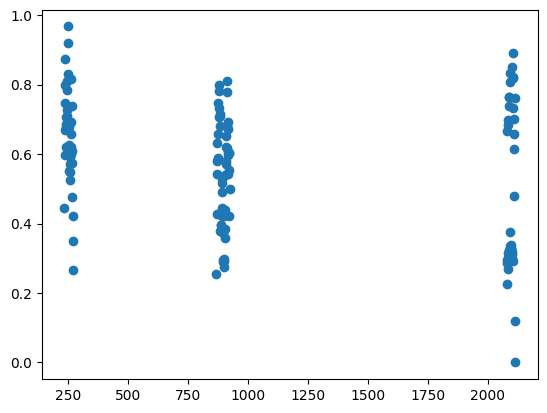

In [48]:
plt.scatter(df_evaluation.iloc[0].frames_iou.keys(), df_evaluation.iloc[0].frames_iou.values())

In [52]:
df_ground_truth.loc['cfg_raw_cam_01_fhd_h265_20230609T050002.mkv'].sort_values('frame_id')

,camera_id,datetime,frame_id,label_class,x,y,w,h,confidance,date
filename,,,,,,,,,,
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1087,8,1332,544,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1088,8,1331,542,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1089,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1090,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1091,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1092,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1093,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1094,8,1309,554,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1095,8,1310,553,187,81,1,2023-06-09


<Axes: xlabel='filename'>

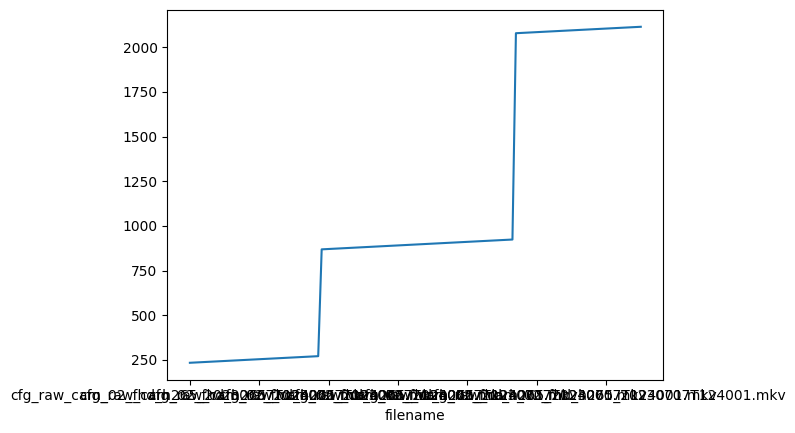

In [24]:
df_ground_truth.loc['cfg_raw_cam_02_fhd_h265_20230707T124001.mkv'].sort_values('frame_id').frame_id.plot()

In [55]:
convert_frame_id = 1087
convert_frame_id / 4 / 60, convert_frame_id / 4 // 60, convert_frame_id / 4 % 60

(4.529166666666667, 4.0, 31.75)

<Axes: xlabel='filename'>

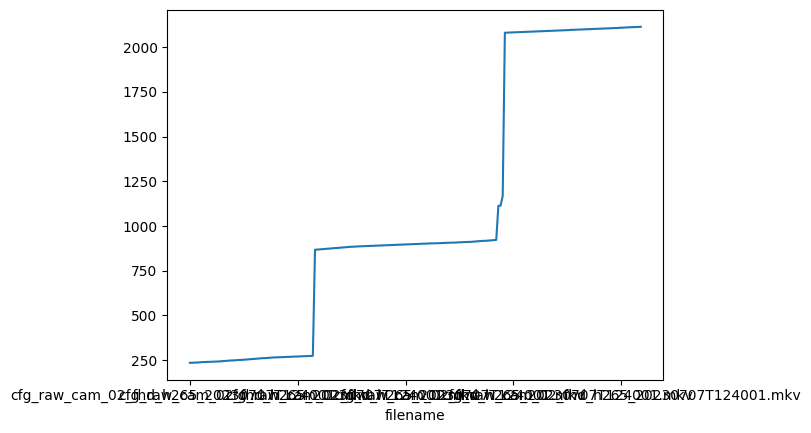

In [29]:
df_tmp = df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T124001.mkv']
df_tmp[df_tmp.x < 1800].sort_values('frame_id').frame_id.plot()

In [31]:
df_tmp[(df_tmp.x < 1800) & (df_tmp.frame_id > 1000)].sort_values('frame_id')

,camera_id,datetime,frame_id,label_class,x,y,w,h,confidence,date
filename,,,,,,,,,,
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,1113,8,15,435,31,25,0.276228,2023-07-07
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,1114,8,15,434,31,23,0.257733,2023-07-07
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,1167,8,719,757,15,9,0.255633,2023-07-07
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,2081,8,1785,558,267,99,0.909898,2023-07-07
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,2081,8,1785,491,267,232,0.430927,2023-07-07
...,...,...,...,...,...,...,...,...,...,...
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,2112,8,97,527,193,96,0.752612,2023-07-07
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,2112,8,105,429,209,298,0.461435,2023-07-07
cfg_raw_cam_02_fhd_h265_20230707T124001.mkv,2,2023-07-07 12:40:01,2113,8,78,527,156,99,0.620677,2023-07-07
